# モジュールのインポート

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
%matplotlib inline

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score
from sklearn import grid_search

from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold

from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve

C:\Users\Tomori kengo\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Tomori kengo\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# データの読み込み

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# 前処理

In [5]:
# 各カラムの欠損値の確認
print(df_train.isnull().sum())
print(df_test.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [6]:
# Embarkedの欠損値補完
# 最頻値を確認
df_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [7]:
# 最頻値のSで欠損値を補完
df_train['Embarked'] = df_train['Embarked'].fillna('S')

In [8]:
# Sの数が+2されているか確認
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [9]:
# SibSp:spouses aboard the Titanic(タイタニックに乗船している配偶者)
# Parch:children aboard the Titanic(タイタニックに乗船している子供) 
# これらの和に+1することで世帯数を表現する
df_train['Family'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['Family'] = df_test['SibSp'] + df_test['Parch'] + 1

In [10]:
# 世帯数=1を1, 世帯数=2以上を0とするカラムAloneを作成
Alone_list = []

for i in range(len(df_train)):
    data = df_train.iloc[i, :]
    if data['Family'] == 1:
        Alone_list.append(1)
    else :
        Alone_list.append(0)
df_train['Alone'] = Alone_list

In [11]:
Alone_list = []

for i in range(len(df_test)):
    data = df_test.iloc[i, :]
    if data['Family'] == 1:
        Alone_list.append(1)
    else :
        Alone_list.append(0)
df_test['Alone'] = Alone_list

In [12]:
# Ageの欠損値を中央値で補完
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].median())
df_test['Age'] = df_test['Age'].fillna(df_test['Age'].median())

In [13]:
# Fareの欠損値を中央値で補完
df_test['Fare'] = df_test['Fare'].fillna(df_test['Fare'].median())

In [14]:
df_train.pivot_table(index='Pclass', columns='SibSp', values='Survived', aggfunc='mean')

SibSp,0,1,2,3,4,5,8
Pclass,,,,,,,
1,0.562044,0.746479,0.800000,0.666667,NaN,NaN,NaN
2,0.416667,0.581818,0.500000,1.000000,NaN,NaN,NaN
3,0.236467,0.325301,0.333333,0.083333,0.166667,0.0,0.0


In [15]:
df_train.pivot_table(index='Pclass', columns='Parch', values='Survived', aggfunc='mean')

Parch,0,1,2,3,4,5,6
Pclass,,,,,,,
1,0.607362,0.677419,0.761905,NaN,0.0,NaN,NaN
2,0.358209,0.750000,0.812500,1.000000,NaN,NaN,NaN
3,0.225722,0.363636,0.255814,0.333333,0.0,0.2,0.0


In [16]:
# Pclass×Familyのクロス集計でSurvivedの値の平均値を確認
df_train.pivot_table(index='Pclass', columns='Family', values='Survived', aggfunc='mean')

Family,1,2,3,4,5,6,7,8,11
Pclass,,,,,,,,,
1,0.532110,0.728571,0.750000,0.714286,1.0,0.5,NaN,NaN,NaN
2,0.346154,0.529412,0.677419,0.769231,1.0,1.0,NaN,NaN,NaN
3,0.212963,0.350877,0.425532,0.666667,0.0,0.0,0.333333,0.0,0.0


In [17]:
df_train.pivot_table(index='Pclass', columns='Sex', values='Survived', aggfunc='mean')

Sex,female,male
Pclass,,
1,0.968085,0.368852
2,0.921053,0.157407
3,0.500000,0.135447


In [18]:
# 文字型データをダミー変換
# df_train['Sex'] = pd.get_dummies(df_train['Sex'])
df_train['Embarked'] = pd.get_dummies(df_train['Embarked'])
# df_test['Sex'] = pd.get_dummies(df_test['Sex'])
df_test['Embarked'] = pd.get_dummies(df_test['Embarked'])

In [19]:
# 処理が難しいカラムはいったん削除
df_train = df_train.drop(['Name', 'Ticket', 'Cabin'], axis=1)
df_test = df_test.drop(['Name', 'Ticket', 'Cabin'], axis=1)

In [20]:
# 上記処理で欠損値が消えたかどうか確認
print(df_train.isnull().sum())
print(df_train.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Family         0
Alone          0
dtype: int64
PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Family         0
Alone          0
dtype: int64


In [22]:
first_female = []

for i in range(len(df_train)):
    data = df_train.iloc[i, :]
    if data['Pclass'] == 1 and data['Sex'] == 'female':
        first_female.append(1)
    else:
        first_female.append(0)
df_train['first_female'] = first_female

In [23]:
second_female = []

for i in range(len(df_train)):
    data = df_train.iloc[i, :]
    if data['Pclass'] == 2 and data['Sex'] == 'female':
        second_female.append(1)
    else:
        second_female.append(0)
df_train['second_female'] = second_female

In [24]:
third_female = []

for i in range(len(df_train)):
    data = df_train.iloc[i, :]
    if data['Pclass'] == 3 and data['Sex'] == 'female':
        third_female.append(1)
    else:
        third_female.append(0)
df_train['third_female'] = third_female

In [25]:
first_male = []

for i in range(len(df_train)):
    data = df_train.iloc[i, :]
    if data['Pclass'] == 1 and data['Sex'] == 'male':
        first_male.append(1)
    else:
        first_male.append(0)
df_train['first_male'] = first_male

In [26]:
second_male = []

for i in range(len(df_train)):
    data = df_train.iloc[i, :]
    if data['Pclass'] == 2 and data['Sex'] == 'male':
        second_male.append(1)
    else:
        second_male.append(0)
df_train['second_male'] = second_male

In [27]:
third_male = []

for i in range(len(df_train)):
    data = df_train.iloc[i, :]
    if data['Pclass'] == 3 and data['Sex'] == 'male':
        third_male.append(1)
    else:
        third_male.append(0)
df_train['third_male'] = third_male

In [28]:
df_train.head(20)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Alone,first_female,second_female,third_female,first_male,second_male,third_male
0,1,0,3,male,22.0,1,0,7.2500,0,2,0,0,0,0,0,0,1
1,2,1,1,female,38.0,1,0,71.2833,1,2,0,1,0,0,0,0,0
2,3,1,3,female,26.0,0,0,7.9250,0,1,1,0,0,1,0,0,0
3,4,1,1,female,35.0,1,0,53.1000,0,2,0,1,0,0,0,0,0
4,5,0,3,male,35.0,0,0,8.0500,0,1,1,0,0,0,0,0,1
5,6,0,3,male,28.0,0,0,8.4583,0,1,1,0,0,0,0,0,1
6,7,0,1,male,54.0,0,0,51.8625,0,1,1,0,0,0,1,0,0
7,8,0,3,male,2.0,3,1,21.0750,0,5,0,0,0,0,0,0,1
8,9,1,3,female,27.0,0,2,11.1333,0,3,0,0,0,1,0,0,0
9,10,1,2,female,14.0,1,0,30.0708,1,2,0,0,1,0,0,0,0


In [29]:
first_female2 = []

for i in range(len(df_test)):
    data = df_test.iloc[i, :]
    if data['Pclass'] == 1 and data['Sex'] == 'female':
        first_female2.append(1)
    else:
        first_female2.append(0)
df_test['first_female'] = first_female2

In [30]:
second_female2 = []

for i in range(len(df_test)):
    data = df_test.iloc[i, :]
    if data['Pclass'] == 2 and data['Sex'] == 'female':
        second_female2.append(1)
    else:
        second_female2.append(0)
df_test['second_female'] = second_female2

In [31]:
third_female2 = []

for i in range(len(df_test)):
    data = df_test.iloc[i, :]
    if data['Pclass'] == 3 and data['Sex'] == 'female':
        third_female2.append(1)
    else:
        third_female2.append(0)
df_test['third_female'] = third_female2

In [32]:
first_male2 = []

for i in range(len(df_test)):
    data = df_test.iloc[i, :]
    if data['Pclass'] == 1 and data['Sex'] == 'male':
        first_male2.append(1)
    else:
        first_male2.append(0)
df_test['first_male'] = first_male2

In [33]:
second_male2 = []

for i in range(len(df_test)):
    data = df_test.iloc[i, :]
    if data['Pclass'] == 2 and data['Sex'] == 'male':
        second_male2.append(1)
    else:
        second_male2.append(0)
df_test['second_male'] = second_male2

In [34]:
third_male2 = []

for i in range(len(df_test)):
    data = df_test.iloc[i, :]
    if data['Pclass'] == 3 and data['Sex'] == 'male':
        third_male2.append(1)
    else:
        third_male2.append(0)
df_test['third_male'] = third_male2

In [35]:
df_test.head(20)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Alone,first_female,second_female,third_female,first_male,second_male,third_male
0,892,3,male,34.5,0,0,7.8292,0,1,1,0,0,0,0,0,1
1,893,3,female,47.0,1,0,7.0000,0,2,0,0,0,1,0,0,0
2,894,2,male,62.0,0,0,9.6875,0,1,1,0,0,0,0,1,0
3,895,3,male,27.0,0,0,8.6625,0,1,1,0,0,0,0,0,1
4,896,3,female,22.0,1,1,12.2875,0,3,0,0,0,1,0,0,0
5,897,3,male,14.0,0,0,9.2250,0,1,1,0,0,0,0,0,1
6,898,3,female,30.0,0,0,7.6292,0,1,1,0,0,1,0,0,0
7,899,2,male,26.0,1,1,29.0000,0,3,0,0,0,0,0,1,0
8,900,3,female,18.0,0,0,7.2292,1,1,1,0,0,1,0,0,0
9,901,3,male,21.0,2,0,24.1500,0,3,0,0,0,0,0,0,1


In [36]:
# Pclass×Sexの値を格納する新しいカラムの準備
# male=1, female=-1に変換
df_train['Sex'] = df_train['Sex'].replace('male', 1).replace('female', -1 )
df_test['Sex'] = df_test['Sex'].replace('male', 1).replace('female', -1 )

In [37]:
# 変換できているかどうか確認
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Alone,first_female,second_female,third_female,first_male,second_male,third_male
0,1,0,3,1,22.0,1,0,7.2500,0,2,0,0,0,0,0,0,1
1,2,1,1,-1,38.0,1,0,71.2833,1,2,0,1,0,0,0,0,0
2,3,1,3,-1,26.0,0,0,7.9250,0,1,1,0,0,1,0,0,0
3,4,1,1,-1,35.0,1,0,53.1000,0,2,0,1,0,0,0,0,0
4,5,0,3,1,35.0,0,0,8.0500,0,1,1,0,0,0,0,0,1


In [38]:
# Pclass の値にSexの値を加えた新しいカラムPSを作成
# female=-1にすることでdf_train['Pclass'] + df_train['Sex']とすることで階級が高い女性ほど値が小さくなるようにする
df_train['PS'] = df_train['Pclass'] + df_train['Sex']
df_test['PS'] = df_test['Pclass'] + df_test['Sex']

In [39]:
# 作成カラムの確認
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Alone,first_female,second_female,third_female,first_male,second_male,third_male,PS
0,1,0,3,1,22.0,1,0,7.2500,0,2,0,0,0,0,0,0,1,4
1,2,1,1,-1,38.0,1,0,71.2833,1,2,0,1,0,0,0,0,0,0
2,3,1,3,-1,26.0,0,0,7.9250,0,1,1,0,0,1,0,0,0,2
3,4,1,1,-1,35.0,1,0,53.1000,0,2,0,1,0,0,0,0,0,0
4,5,0,3,1,35.0,0,0,8.0500,0,1,1,0,0,0,0,0,1,4


In [40]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Alone,first_female,second_female,third_female,first_male,second_male,third_male,PS
0,892,3,1,34.5,0,0,7.8292,0,1,1,0,0,0,0,0,1,4
1,893,3,-1,47.0,1,0,7.0000,0,2,0,0,0,1,0,0,0,2
2,894,2,1,62.0,0,0,9.6875,0,1,1,0,0,0,0,1,0,3
3,895,3,1,27.0,0,0,8.6625,0,1,1,0,0,0,0,0,1,4
4,896,3,-1,22.0,1,1,12.2875,0,3,0,0,0,1,0,0,0,2


In [41]:
# ダミー変数がマイナスのままだと予測結果に影響する？ので0,1データにする
# replaceする元データが数値データのときはクォーテーション指定する必要なし
df_train['Sex'] = df_train['Sex'].replace(1, 1).replace(-1, 0 )
df_test['Sex'] = df_test['Sex'].replace(1, 1).replace(-1, 0 )

In [42]:
df_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Alone,first_female,second_female,third_female,first_male,second_male,third_male,PS
0,1,0,3,1,22.0,1,0,7.2500,0,2,0,0,0,0,0,0,1,4
1,2,1,1,0,38.0,1,0,71.2833,1,2,0,1,0,0,0,0,0,0
2,3,1,3,0,26.0,0,0,7.9250,0,1,1,0,0,1,0,0,0,2
3,4,1,1,0,35.0,1,0,53.1000,0,2,0,1,0,0,0,0,0,0
4,5,0,3,1,35.0,0,0,8.0500,0,1,1,0,0,0,0,0,1,4


In [43]:
df_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Alone,first_female,second_female,third_female,first_male,second_male,third_male,PS
0,892,3,1,34.5,0,0,7.8292,0,1,1,0,0,0,0,0,1,4
1,893,3,0,47.0,1,0,7.0000,0,2,0,0,0,1,0,0,0,2
2,894,2,1,62.0,0,0,9.6875,0,1,1,0,0,0,0,1,0,3
3,895,3,1,27.0,0,0,8.6625,0,1,1,0,0,0,0,0,1,4
4,896,3,0,22.0,1,1,12.2875,0,3,0,0,0,1,0,0,0,2


In [44]:
# 20歳以下かどうかを示すカラム「Child」を作成
# カラムの追加にはassign関数
# ダミー変数にするためにastype(int)を付ける
df_train = df_train.assign(Child = (df_train['Age'] < 20).astype(int))
df_test = df_test.assign(Child = (df_test['Age'] < 20).astype(int))

In [45]:
df_train.head(10)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Alone,first_female,second_female,third_female,first_male,second_male,third_male,PS,Child
0,1,0,3,1,22.0,1,0,7.2500,0,2,0,0,0,0,0,0,1,4,0
1,2,1,1,0,38.0,1,0,71.2833,1,2,0,1,0,0,0,0,0,0,0
2,3,1,3,0,26.0,0,0,7.9250,0,1,1,0,0,1,0,0,0,2,0
3,4,1,1,0,35.0,1,0,53.1000,0,2,0,1,0,0,0,0,0,0,0
4,5,0,3,1,35.0,0,0,8.0500,0,1,1,0,0,0,0,0,1,4,0
5,6,0,3,1,28.0,0,0,8.4583,0,1,1,0,0,0,0,0,1,4,0
6,7,0,1,1,54.0,0,0,51.8625,0,1,1,0,0,0,1,0,0,2,0
7,8,0,3,1,2.0,3,1,21.0750,0,5,0,0,0,0,0,0,1,4,1
8,9,1,3,0,27.0,0,2,11.1333,0,3,0,0,0,1,0,0,0,2,0
9,10,1,2,0,14.0,1,0,30.0708,1,2,0,0,1,0,0,0,0,1,1


In [46]:
df_test.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Alone,first_female,second_female,third_female,first_male,second_male,third_male,PS,Child
0,892,3,1,34.5,0,0,7.8292,0,1,1,0,0,0,0,0,1,4,0
1,893,3,0,47.0,1,0,7.0000,0,2,0,0,0,1,0,0,0,2,0
2,894,2,1,62.0,0,0,9.6875,0,1,1,0,0,0,0,1,0,3,0
3,895,3,1,27.0,0,0,8.6625,0,1,1,0,0,0,0,0,1,4,0
4,896,3,0,22.0,1,1,12.2875,0,3,0,0,0,1,0,0,0,2,0
5,897,3,1,14.0,0,0,9.2250,0,1,1,0,0,0,0,0,1,4,1
6,898,3,0,30.0,0,0,7.6292,0,1,1,0,0,1,0,0,0,2,0
7,899,2,1,26.0,1,1,29.0000,0,3,0,0,0,0,0,1,0,3,0
8,900,3,0,18.0,0,0,7.2292,1,1,1,0,0,1,0,0,0,2,1
9,901,3,1,21.0,2,0,24.1500,0,3,0,0,0,0,0,0,1,4,0


In [47]:
df_train.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family,Alone,first_female,second_female,third_female,first_male,second_male,third_male,PS,Child
PassengerId,1.000000,-0.005007,-0.035144,0.042939,0.034212,-0.057527,-0.001652,0.012658,-0.001205,-0.040143,0.057462,0.030994,-0.003437,-0.078984,0.015067,0.002834,0.029548,0.008638,-0.016721
Survived,-0.005007,1.000000,-0.338481,-0.543351,-0.064910,-0.035322,0.081629,0.257307,0.168240,0.016639,-0.203367,0.412581,0.337329,0.104873,-0.012274,-0.172920,-0.407925,-0.594185,0.095582
Pclass,-0.035144,-0.338481,1.000000,0.131900,-0.339898,0.083081,0.018443,-0.549500,-0.243292,0.065997,0.135207,-0.537844,-0.112793,0.363266,-0.623790,-0.137179,0.660798,0.712469,0.126098
Sex,0.042939,-0.543351,0.131900,1.000000,0.081163,-0.114631,-0.245489,-0.182333,-0.082853,-0.200988,0.303646,-0.465541,-0.413953,-0.595174,0.293828,0.273973,0.589172,0.789548,-0.104297
Age,0.034212,-0.064910,-0.339898,0.081163,1.000000,-0.233296,-0.172482,0.096688,0.030248,-0.245619,0.171647,0.121857,-0.015433,-0.195318,0.294884,0.032843,-0.150357,-0.152976,-0.634446
SibSp,-0.057527,-0.035322,0.083081,-0.114631,-0.233296,1.000000,0.414838,0.159651,-0.059528,0.890712,-0.584471,0.009405,-0.010021,0.148524,-0.076447,-0.060796,-0.017717,-0.029710,0.255485
Parch,-0.001652,0.081629,0.018443,-0.245489,-0.172482,0.414838,1.000000,0.216225,-0.011069,0.783111,-0.583398,0.032336,0.084784,0.227276,-0.050878,-0.073472,-0.155459,-0.162361,0.260339
Fare,0.012658,0.257307,-0.549500,-0.182333,0.096688,0.159651,0.216225,1.000000,0.269335,0.217138,-0.271832,0.511153,-0.062925,-0.142199,0.280868,-0.093192,-0.314262,-0.469265,-0.003916
Embarked,-0.001205,0.168240,-0.243292,-0.082853,0.030248,-0.059528,-0.011069,0.269335,1.000000,-0.046215,-0.095298,0.236086,-0.075296,-0.032361,0.158558,-0.091112,-0.131969,-0.209273,-0.014235
Family,-0.040143,0.016639,0.065997,-0.200988,-0.245619,0.890712,0.783111,0.217138,-0.046215,1.000000,-0.690922,0.022583,0.035508,0.215054,-0.077667,-0.078257,-0.089774,-0.101419,0.304676


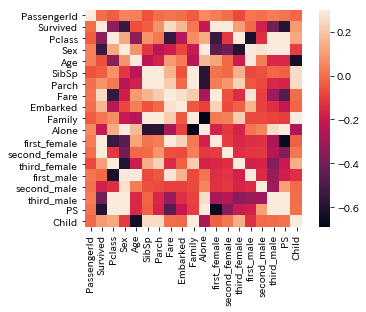

In [52]:
corrmat = df_train.corr()
sns.heatmap(corrmat, vmax=.30, square=True)

# モデル作成

In [ ]:
# 今回はPassengerId,Survived以外を特徴量にする

In [53]:
train_X = df_train.drop(['PassengerId', 'Survived'], axis = 1)

In [54]:
train_y = df_train['Survived']

In [55]:
model = RandomForestClassifier(n_estimators=50, random_state=0)

In [56]:
model.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [57]:
train_X.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Family',
       'Alone', 'first_female', 'second_female', 'third_female', 'first_male',
       'second_male', 'third_male', 'PS', 'Child'],
      dtype='object')

In [58]:
# 特徴量毎にランダムフォレストの重要度を確認
for c, m in zip(train_X.columns, model.feature_importances_):
    # print(c, m)
    print('{} : {}'.format(c, m))

Pclass : 0.01896625958162175
Sex : 0.0992839357914243
Age : 0.22780338643930617
SibSp : 0.02528268319053308
Parch : 0.02261843970344306
Fare : 0.23660444545893167
Embarked : 0.01955527410233605
Family : 0.03770496913453623
Alone : 0.0102841354240061
first_female : 0.046537863611090954
second_female : 0.03567378528426408
third_female : 0.01655284063271341
first_male : 0.009467615916330673
second_male : 0.007289547659889864
third_male : 0.03608014858328567
PS : 0.1327108163141414
Child : 0.01758385317214555


# 予測

In [59]:
test_X = df_test.drop(['PassengerId'], axis=1)

In [60]:
pred_y = model.predict(test_X)

In [61]:
pred_y[:10]

array([0, 0, 1, 1, 0, 0, 0, 0, 1, 0], dtype=int64)

# 提出ファイル作成

In [62]:
output = pd.read_csv('test.csv')

In [63]:
output['Survived'] = pred_y

In [64]:
output[['PassengerId','Survived']].to_csv('submission_180921_2.csv', index=False)

In [ ]:
# score = 0.75598 Best Entry